In [2]:
import os
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import warnings



from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

In [3]:
def format_congress_text(text_list):
    df = pd.DataFrame(text_list, columns=["text_raw"])

    df["text_raw"] = df["text_raw"].str.split("\n</TEXT>\n</DOC>\n\n<DOC>\n<DOCNO>")

    df = df.explode("text_raw")

    df["text_raw"] = df["text_raw"].str.replace("<DOC>\n<DOCNO>", "")

    df["meta"] = df["text_raw"].str.split("</DOCNO>\n<TEXT>\n").str[0]
    df["congress"] = df["meta"].str[:3]
    df["speaker"] = df["meta"].str.split("-").str[1]
    df["state"] = df["meta"].str.split("-").str[2]
    df["date"] = df["meta"].str.split("-").str[4]

    df["text_raw"] = (
        df["text_raw"]
        .str.split("</DOCNO>\n<TEXT>\n")
        .str[1]
        .str.strip()
        .str.split(".")
        .str[2:]
        .str.join(sep="")
        .str.strip()
    )

    df["text_raw"] = df["text_raw"] + " "

    # now join this back to congress / speaker level

    df = df.groupby(["congress", "speaker"])["text_raw"].sum().reset_index()

    # drop if a congressman did not speek
    df = df.loc[lambda x: x["text_raw"].apply(type) == str]
    return df

In [4]:
import os 
os.getcwd()

'C:\\Users\\molda\\Downloads'

In [5]:
droplist = open("ML-for-NLP-main/Inputs/droplist.txt", encoding="utf-8", newline="\n").read()
droplist = [i.replace('"', "") for i in droplist.split("\n")]
stop_words = stopwords.words("english")
stopwords_final = droplist + stop_words + ['s','nt', "n't"]

In [6]:
text_105 = [
    open("ML-for-NLP-main/Inputs/105-extracted-date/" + i, encoding="latin").read()
    for i in os.listdir("ML-for-NLP-main/Inputs/105-extracted-date/")
]

df = format_congress_text(text_105)

In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
def preprocessing_text(text):
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in string.punctuation]
    tokens = [token for token in tokens if token not in stopwords_final]
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

In [9]:
vectorizer = TfidfVectorizer(preprocessor = preprocessing_text)
dtm_tfidf = vectorizer.fit_transform(df["text_raw"])
df_tfidf = pd.DataFrame(dtm_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [10]:
df_tfidf.to_pickle("tfidf.pkl")

### calculate similarity

In [11]:
df

congress     speaker                                           text_raw
0       105     abraham  Mr President, during debate on final passage o...
1       105       akaka  Mr President, I am pleased that the Senate pas...
2       105      allard  Mr President, I rise to make a few remarks con...
3       105    ashcroft  Mr President, the Senate is not in order I wou...
4       105      baucus  I understand that the House has sent the Senat...
..      ...         ...                                                ...
94      105    thurmond  Mr President, as the Senate considers HR 2263,...
95      105  torricelli  Mr President I thank Senator Snowe, Senator Mc...
96      105      warner  During the past two weeks, the Senate Armed Se...
97      105   wellstone  Mr President, today, I would like to call atte...
98      105       wyden  Mr President, today Congress passed a version ...

[99 rows x 3 columns]

In [12]:
biden=df.loc[df["speaker"] == "biden", "text_raw"].item()

In [13]:
biden = preprocessing_text(biden)

In [14]:
biden

"president pleased senate passing hatch-biden-lautenberg substitute amendment hr 4164 hopeful body pass measure congress adjourns legislation simple current federal law faith credit child custody custody defined including visitation evidence country shown courts automatically recognize visitation particularly visitation child 's parent grandparent courts supposed honor arduous process getting legislation simply clarifies faith credit law includes visitation absolutely courts visitation entered consistently provisions federal faith credit statute faith credit narrow legal sense current federal law law explicit hopefully eliminate hassles obstacles delays confront valid visitation federal law followed president author idea representative rob andrews jersey deserves credit bringing issue attention day 1997 introduced bill visitation tireless pushing passage commend congratulate finally thank senator willingness move bill final days session lot pressing issue lost final crunch chairman sta

In [15]:
from collections import Counter
dict_counts = Counter(biden.split())
sorted(dict_counts.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('--', 2465),
 ('president', 1517),
 ("'s", 1345),
 ('senator', 1003),
 ('nato', 941),
 ('united', 653),
 ('time', 635),
 ('bill', 570),
 ('amendment', 480),
 ('senate', 476)]

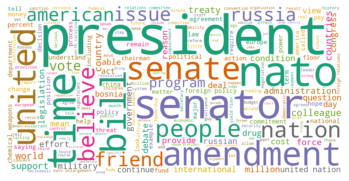

In [16]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stopwords_final, width=1800, height=900, background_color="white", colormap="Dark2",
               relative_scaling = 0.5)
wc.generate(biden)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
biden_vector = df_tfidf.loc[df["speaker"] == "biden"].values.reshape(1, -1)

docs = df_tfidf.values

In [19]:
similarity = []
for doc in docs:
    similarity.append(cosine_similarity(doc.reshape(1,-1), biden_vector))

In [20]:
df["text_similarity_to_biden"] = [i[0][0] for i in similarity]

In [21]:
df_105kh=df.sort_values(by=["text_similarity_to_biden"], ascending=False).head(12).merge(
    pd.read_csv("ML-for-NLP-main/Inputs/sen105kh_fix.csv", sep=";"),
    left_on="speaker",
    right_on="lname",
    how="left",
)

In [22]:
df.sort_values(by=["text_similarity_to_biden"], ascending=False).head(6).merge(
    pd.read_csv("ML-for-NLP-main/Inputs/sen105kh_fix.csv", sep=";"),
    left_on="speaker",
    right_on="lname",
    how="left",
)

congress    speaker                                           text_raw  \
0      105      biden  Mr President, I am pleased that the Senate tod...   
1      105      smith  Mr President, I rise to indicate my strong sup...   
2      105      smith  Mr President, I rise to indicate my strong sup...   
3      105    roberts  I thank the Chair I thank the Presiding Office...   
4      105  hutchison  I am happy to yield to the Senator from Indian...   
5      105     warner  During the past two weeks, the Senate Armed Se...   
6      105      kerry  Mr President, I would ask my distinguished col...   

   text_similarity_to_biden  cong      lname stateab   lstate     id  dist  \
0                  1.000000   105      biden      de  DELAWAR  14101     0   
1                  0.783004   105      smith      nh  NEW HAM  15116     0   
2                  0.783004   105      smith      or  OREGON   49705     0   
3                  0.778932   105    roberts      ks  KANSAS   14852     0   
4                  0.771707   105  hutchison      tx  TEXAS    49306     0   
5                  0.771211   105     warner      va  VIRGINI  14712     0   
6                  0.768936   105      kerry      ma  MASSACH  14920     0   

   party  
0    100  
1    200  
2    200  
3    200  
4    200  
5    200  
6    100

**Our finding: The closest to senator Biden's speech is Smith, with a high similarity of 0.783004 (so the wordcloud visualization is similar), and it is clear that he is not from the same state as senator Biden.**

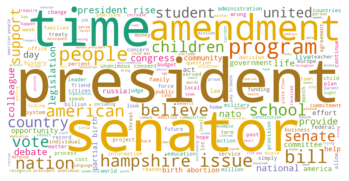

In [23]:
smith=df.loc[df["speaker"] == "smith", "text_raw"].item()
smith = preprocessing_text(smith)
wc.generate(smith)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
(df_105kh['speaker']+" "+df_105kh['stateab']+" "+df_105kh['party'].astype(str))

0         biden de 100
1         smith nh 200
2         smith or 200
3       roberts ks 200
4     hutchison tx 200
5        warner va 200
6         kerry ma 100
7           kyl az 200
8          byrd wv 100
9     lieberman ct 100
10        hagel ne 200
11        levin mi 100
12       mccain az 200
dtype: object

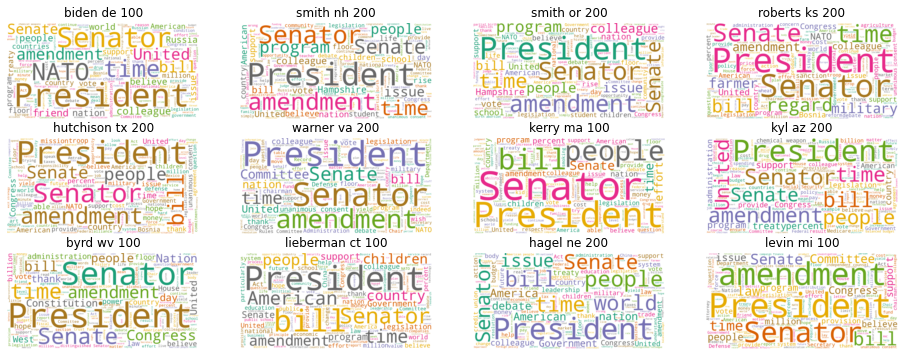

In [25]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

full_names = (df_105kh['speaker']+" "+df_105kh['stateab']+" "+df_105kh['party'].astype(str)).to_list()

# Create subplots for each comedian
for a in range(12):
    wc.generate(df_105kh.text_raw[a])
    
    plt.subplot(3, 4, a+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[a])
    
plt.show()
    

In [26]:
df_105kh=df.sort_values(by=["text_similarity_to_biden"], ascending=False).merge(
    pd.read_csv("ML-for-NLP-main/Inputs/sen105kh_fix.csv", sep=";"),
    left_on="speaker",
    right_on="lname",
    how="left",
)

In [27]:
df_105kh[df_105kh['text_similarity_to_biden']>0.7]["party"].value_counts()

200    23
100    17
Name: party, dtype: int64

In [28]:
df_105kh[df_105kh['text_similarity_to_biden']>0.5]["party"].value_counts()

200    54
100    45
Name: party, dtype: int64

In [29]:
df_105kh[df_105kh['text_similarity_to_biden']>0.7]["lstate"].value_counts().head()

DELAWAR    2
CONNECT    2
NEW YOR    2
NEW MEX    2
NEW JER    2
Name: lstate, dtype: int64

In [30]:
df_105kh[df_105kh['text_similarity_to_biden']>0.5]["lstate"].value_counts().head()

DELAWAR    2
NEW HAM    2
VERMONT    2
ALABAMA    2
GEORGIA    2
Name: lstate, dtype: int64

### LDA

In [31]:
from gensim import models
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import re
import numpy as np
from gensim import corpora

In [32]:
tokenizer = RegexpTokenizer(r'\w+')
def prepare_text_for_lda(text):
    text= re.sub(r'\d', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return tokens

In [33]:
df['tokens'] = df['text_raw'].apply(lambda x: prepare_text_for_lda(x))

In [34]:
df.head()

congress   speaker                                           text_raw  \
0      105   abraham  Mr President, during debate on final passage o...   
1      105     akaka  Mr President, I am pleased that the Senate pas...   
2      105    allard  Mr President, I rise to make a few remarks con...   
3      105  ashcroft  Mr President, the Senate is not in order I wou...   
4      105    baucus  I understand that the House has sent the Senat...   

   text_similarity_to_biden                                             tokens  
0                  0.720345  [mr, president, during, debate, on, final, pas...  
1                  0.508169  [mr, president, i, am, pleased, that, the, sen...  
2                  0.652450  [mr, president, i, rise, to, make, a, few, rem...  
3                  0.686002  [mr, president, the, senate, is, not, in, orde...  
4                  0.682540  [i, understand, that, the, house, has, sent, t...

In [35]:
pos_tag(['president']) 

[('president', 'NN')]

In [36]:
from nltk.corpus import wordnet
# original example can be found here https://stackoverflow.com/a/15590384

def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [37]:
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos=wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

In [38]:
get_lemma('went')

'go'

In [39]:
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos = wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

def convert(list_element):
    tokens = [get_lemma(token) for token in list_element]
    tokens = [token for token in tokens if token not in stopwords_final]
    tokens = [token for token in tokens if len(token) > 3]
    return tokens

In [40]:
df['tokens'] = df['tokens'].progress_apply(lambda sentences: convert(sentences))

  0%|          | 0/99 [00:00<?, ?it/s]

In [41]:
df['tokens'].to_pickle("lda_prep_text.pkl")

In [42]:
df["tokens"] = pd.read_pickle("lda_prep_text.pkl")

In [43]:
df.head()

congress   speaker                                           text_raw  \
0      105   abraham  Mr President, during debate on final passage o...   
1      105     akaka  Mr President, I am pleased that the Senate pas...   
2      105    allard  Mr President, I rise to make a few remarks con...   
3      105  ashcroft  Mr President, the Senate is not in order I wou...   
4      105    baucus  I understand that the House has sent the Senat...   

   text_similarity_to_biden                                             tokens  
0                  0.720345  [president, debate, final, passage, omnibus, a...  
1                  0.508169  [president, pleased, senate, pass, veteran, pr...  
2                  0.652450  [president, rise, remark, concern, auto, choic...  
3                  0.686002  [president, senate, hear, senator, senate, hap...  
4                  0.682540  [understand, house, sent, senate, substitute, ...

In [44]:
def get_LDA_model(df, num_topics=7):

    dictionary_LDA = corpora.Dictionary(df["tokens"].tolist())
    dictionary_LDA.filter_extremes(no_below=3)

    corpus = [dictionary_LDA.doc2bow(tok) for tok in df["tokens"].tolist()]

    np.random.seed(123)

    lda_model = models.LdaModel(
        corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4
    )
    return lda_model, corpus, dictionary_LDA

In [45]:
lda_model, corpus, dictionary_LDA = get_LDA_model(df,7)

In [46]:
num_topics = 7
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.003*"cosmetic" + 0.003*"satcher" + 0.002*"decree" + 0.002*"copyright" + 0.002*"visa" + 0.002*"debtor" + 0.002*"hcfa" + 0.002*"creditor" + 0.002*"clone" + 0.002*"baltimore" + 0.002*"sierra" + 0.001*"blanca" + 0.001*"firearm" + 0.001*"teamster" + 0.001*"comptime" + 0.001*"unbalanced" + 0.001*"tissue" + 0.001*"fetus" + 0.001*"slam" + 0.001*"fema"

1: 0.005*"fork" + 0.003*"fema" + 0.003*"tactical" + 0.003*"firearm" + 0.002*"wetland" + 0.002*"puerto" + 0.002*"rico" + 0.002*"wilderness" + 0.002*"fishery" + 0.002*"clone" + 0.002*"denver" + 0.002*"hamre" + 0.002*"opic" + 0.002*"swiss" + 0.002*"hcfa" + 0.002*"arbitration" + 0.001*"superfund" + 0.001*"holocaust" + 0.001*"snow" + 0.001*"cattle"

2: 0.004*"microsoft" + 0.004*"fishery" + 0.003*"spanish" + 0.002*"encryption" + 0.002*"timber" + 0.002*"albuquerque" + 0.002*"seattle" + 0.002*"salmon" + 0.002*"clone" + 0.002*"ranch" + 0.002*"irrigation" + 0.002*"nondefense" + 0.001*"pueblo" + 0.001*"denver" + 0.001*"kosovo" + 0.001*"juan" + 0.001*"

In [47]:
from gensim.models import Phrases
documents = df.text_raw

sentence_stream = [doc.split(" ") for doc in documents]
bigram = Phrases(sentence_stream, min_count=1, threshold=2)

In [48]:
sentence_stream

[['Mr',
  'President,',
  'during',
  'debate',
  'on',
  'final',
  'passage',
  'of',
  'the',
  'Omnibus',
  'Appropriations',
  'bill,',
  'in',
  'which',
  'the',
  'American',
  'Competitiveness',
  'and',
  'Workforce',
  'Improvement',
  'Act',
  'was',
  'included',
  'as',
  'Title',
  'IV',
  'of',
  'Subdivision',
  'C,',
  'I',
  'asked',
  'unanimous',
  'consent',
  'to',
  'have',
  'a',
  'number',
  'of',
  'documents',
  'printed',
  'in',
  'the',
  'Record',
  'These',
  'included',
  'two',
  'documents',
  'I',
  'received',
  'from',
  'the',
  'Administration',
  'during',
  'the',
  'negotiations,',
  'whose',
  'inclusion',
  'I',
  'was',
  'seeking',
  'to',
  'help',
  'illuminate',
  'the',
  'meaning',
  'of',
  'some',
  'of',
  'the',
  'provisions',
  'of',
  'the',
  'legislation',
  'One',
  'of',
  'the',
  'key',
  'points',
  'about',
  'these',
  'documents',
  'is',
  'the',
  'changes',
  'from',
  'the',
  'July',
  '30',
  'version',
  'to'

In [49]:
topics = [lda_model[corpus[i]] for i in range(99)]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [50]:
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]).reset_index(drop=True).fillna(0)

In [51]:
document_topic.to_pickle("document_topic.pkl")

In [52]:
document_topic.sort_values(2, ascending=False)[2].head(20)

29    0.999896
39    0.999852
76    0.999740
16    0.997882
81    0.996135
92    0.988616
61    0.905332
88    0.777905
17    0.674887
7     0.627175
14    0.531339
67    0.269390
18    0.032771
98    0.021119
56    0.014777
70    0.000000
69    0.000000
66    0.000000
68    0.000000
71    0.000000
Name: 2, dtype: float64

<AxesSubplot:>

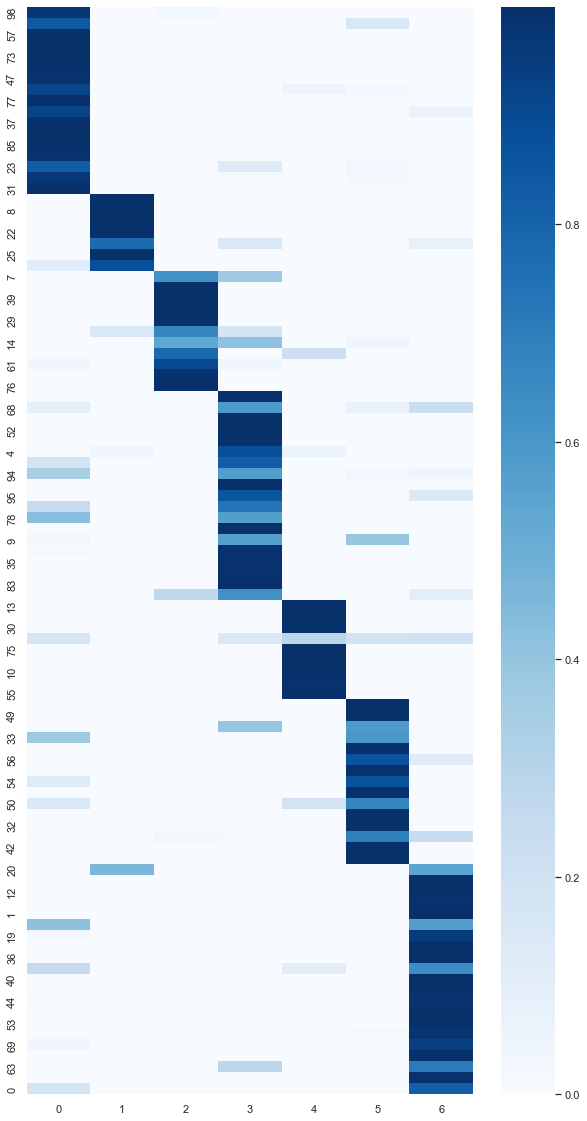

In [53]:
##Looking at the distribution of topics in all documents
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap="Blues")

<AxesSubplot:>

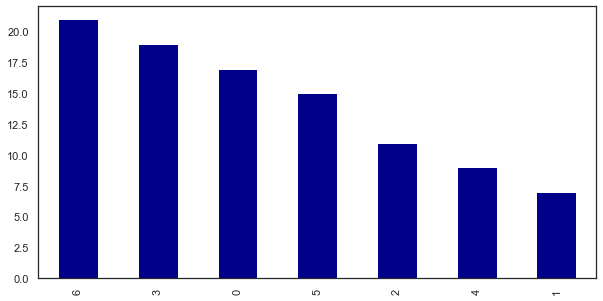

In [54]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white") 
document_topic.idxmax(axis=1).value_counts().plot.bar(color='darkblue')

In [55]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.display(vis)

**Our finding: The above diagram consists of two parts, the intertopic distance map on the left and the bar chart on the right. The area of the topic circles is proportional to the number of words belonging to each topic in the dictionary, so we can visually see that topics 1, 2, and 3 are the largest topics in the data, while topic 7 is the smallest topic in the data.**

## Interpretation

Topic 0 includes words like cosmetic, satcher (david satcher-public health administrator), hcfa (Health Care Finance Administration) as well as visa, creditor and debtor so it is probably about financing medical services. Topic 1 includes fema (Federal Emergency Management Agency), tactical, firearm and so on, therefore it is about emergency situation. Topic 2 is not ideal as it includes microsoft and fishery which are not really connected, but it is mostly in document 39 as it is seen in the heatmap, so below is the text, where a lot of things are discussed and words microsoft and fishery are mentioned many times. Topic 3 includes amtrak, barrel, depot so it is about transportation and oil. Topic 4 is mostly about haiti and it is also not ideal. Topic 5 is also mixed composition, but mostly it covers the Northeast Dairy Compact legislation issue. Topic 6 is probably the most mixed as the weights do not show significantly higher presence of a word.

In [67]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.003*"cosmetic" + 0.003*"satcher" + 0.002*"decree" + 0.002*"copyright" + 0.002*"visa" + 0.002*"debtor" + 0.002*"hcfa" + 0.002*"creditor" + 0.002*"clone" + 0.002*"baltimore" + 0.002*"sierra" + 0.001*"blanca" + 0.001*"firearm" + 0.001*"teamster" + 0.001*"comptime" + 0.001*"unbalanced" + 0.001*"tissue" + 0.001*"fetus" + 0.001*"slam" + 0.001*"fema"

1: 0.005*"fork" + 0.003*"fema" + 0.003*"tactical" + 0.003*"firearm" + 0.002*"wetland" + 0.002*"puerto" + 0.002*"rico" + 0.002*"wilderness" + 0.002*"fishery" + 0.002*"clone" + 0.002*"denver" + 0.002*"hamre" + 0.002*"opic" + 0.002*"swiss" + 0.002*"hcfa" + 0.002*"arbitration" + 0.001*"superfund" + 0.001*"holocaust" + 0.001*"snow" + 0.001*"cattle"

2: 0.004*"microsoft" + 0.004*"fishery" + 0.003*"spanish" + 0.002*"encryption" + 0.002*"timber" + 0.002*"albuquerque" + 0.002*"seattle" + 0.002*"salmon" + 0.002*"clone" + 0.002*"ranch" + 0.002*"irrigation" + 0.002*"nondefense" + 0.001*"pueblo" + 0.001*"denver" + 0.001*"kosovo" + 0.001*"juan" + 0.001*"

<AxesSubplot:>

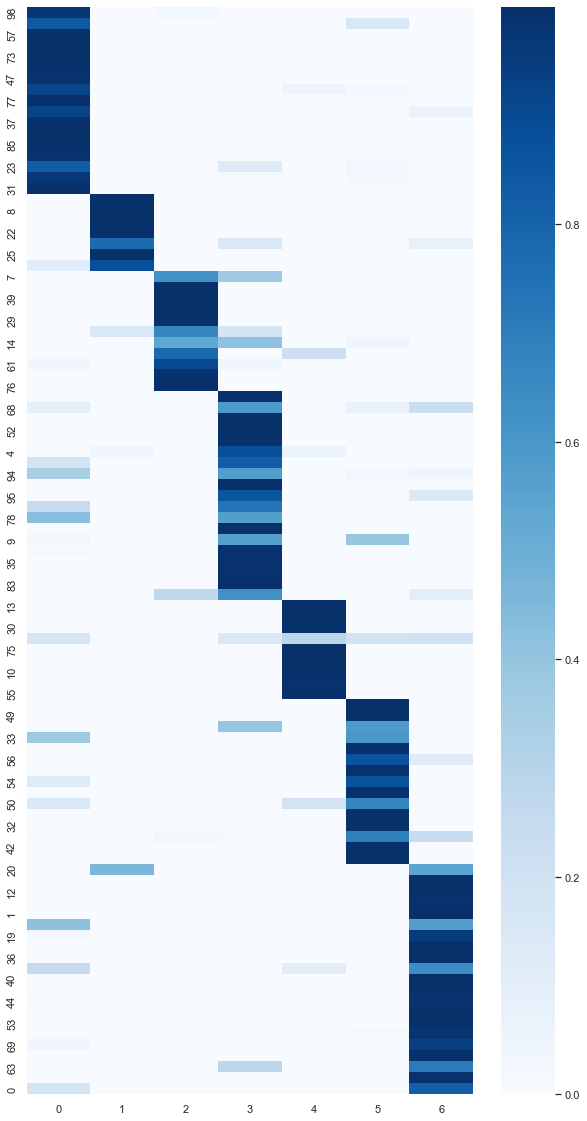

In [68]:
##Looking at the distribution of topics in all documents
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap="Blues")

In [57]:
df["text_raw"][39]

'Mr President, I voted in favor of the omnibus appropriations bill this morning, but I did so with some reluctance While I am marginally pleased with this bill\'s contribution to education and defense, my primary concern is the $209 billion in emergency spending included in this bill that further jeopardizes the Social Security trust fund \nIn July, the Congressional Budget Office predicted the Federal Government will run a $63 billion surplus in 1998 if the Social Security trust fund is included in the budget calculations We still run a $41 billion deficit, however, if the surplus in the Social Security trust fund is excluded The Federal Government will not run a surplus without the inclusion of the Social Security trust fund until 2002, when CBO expects a $1 billion surplus By 2008, the surplus will rise to $64 billion, without counting the Social Security trust fund \nHowever, the omnibus appropriations package includes $209 billion in emergency spending--spending outside of the cap

In [64]:
df["text_raw"][13]

'Mr President, I rise today in strong support of S 1693, the National Parks Omnibus Management Act of 1998 Let me begin by acknowledging the work of the sponsor of this legislation, Senator Thomas As the chairman of the Subcommittee on National Parks, Historic Preservation and Recreation, he has been willing to compromise and work with all involved parties, including Secretary Babbit, my friend and colleague Senator Bennett, Congressmen George Miller and Don Young in an effort to enact a meaningful and comprehensive bill for our national parks It has been a pleasure to work with him on this important legislation and I am very pleased that this bill will pass before I leave the Senate this year I would also like to particularly thank Senator Bennett, who has once again been very helpful and constructive in developing a bill that can garner such broad bipartisan support, as I believe this bill has \nAlthough this is a comprehensive bill that makes a number of positive changes in the way 

In [65]:
df["text_raw"][42]

'Will the Senator from Missouri yield for an unanimous consent request? I ask unanimous consent that following the remarks of the Senator from Missouri I be recognized to speak for up to 15 minutes as in morning business I thank the Senator from Missouri Thank you very much \nMr President, I also rise this morning to discuss my opposition to the omnibus appropriations legislation that was before us this morning \nWhile I realize many of my colleagues would have preferred not to return for this vote, there are a number of us who believed that a vote was essential on a bill that appropriates a third of our spending priorities for fiscal year 1999 \nTo shirk our responsibility to the taxpayers, to hide behind an unrecorded vote, was unconceivable \nI feel strongly that we are elected to represent the American people and to take care of the Nation\'s business The people expect us to be responsible They expect us to be accountable They expect us to be here and do our job In other words, whe

In [66]:
df["text_raw"][12]

"Mr President, the Children's Online Privacy Act was reported out of Committee by voice vote Because of time constraints at the end of the session, we have been unable to file a Committee Report before offering it as an amendment on the Senate floor Accordingly, I wish to take this opportunity to explain the purpose and some of the important features of the amendment \nIn a matter of only a few months since Chairman McCain and I introduced this bill last summer, we have been able to achieve a remarkable consensus This is due in large part to the recognition by a wide range of constituencies that the issue is an important one that requires prompt attention by Congress It is also due to revisions to our original bill that were worked out carefully with the participation of the marketing and online industries, the Federal Trade Commission, privacy groups, and First Amendment organizations \nThe goals of this legislation are: (1) to enhance parental involvement in a child's online activiti